# GLM-Infused SweetNet Experiments

Experimenting with a modified version of SweetNet that allows it to take pre-trained embeddings as input. To get there I need a way to take the embeddings I’ve gotten from roman and transform them into nice inputs for the model, and a way to set the initial features using these inputs. 


## Importing and exploring the GLM Embedding data

### Exploring embeddings

In [ ]:
# quick thing to load a pickle file

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            loaded_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

In [ ]:
# lets do some quick exploration

# --- Explore the loaded data ---
print(f"Type of loaded object: {type(loaded_embeddings)}")

# Common formats for embeddings: dictionary or numpy array
if isinstance(loaded_embeddings, dict):
    print(f"Number of items (if dictionary): {len(loaded_embeddings)}")
    # print some keys to see what they look like
    print(f"Example keys (first 5): {list(loaded_embeddings.keys())[:5]}")
elif hasattr(loaded_embeddings, 'shape'):
    print(f"Shape (if array/tensor): {loaded_embeddings.shape}")
    if hasattr(loaded_embeddings, 'dtype'):
         print(f"Data type (if array/tensor): {loaded_embeddings.dtype}")

In [ ]:
print(list(loaded_embeddings.keys())[5:30]) # Print more keys

In [ ]:
example_key = '!GlcNAc' 
if example_key in loaded_embeddings:
    embedding_vector = loaded_embeddings[example_key]
    print(f"Type of value for '{example_key}': {type(embedding_vector)}")
    if hasattr(embedding_vector, 'shape'):
        print(f"Shape of value: {embedding_vector.shape}") # This gives dimensionality!
        print(f"Dtype of value: {embedding_vector.dtype}")
    print(embedding_vector) # Print the vector itself if it's not too long
else:
    print(f"Key '{example_key}' not found.")

In [ ]:
# let's look at the keys a bit more closely

import collections

key_types = collections.defaultdict(int)
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        key_types['linkage_or_modification'] += 1
    elif key[0].isalpha():
        key_types['monosaccharide'] += 1
    else:
        key_types['other'] += 1

print(key_types)

In [ ]:
# Let's explore those Other keys 

other_keys = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        other_keys.append(key)

print(f"Number of 'other' keys: {len(other_keys)}")
print(f"Examples of 'other' keys: {other_keys[:20]}") # Print the first 20

In [ ]:
# Let's look at 50 more keys

print(f"More Examples of 'other' keys: {other_keys[20:70]}")

In [ ]:
# Let's explore those monosaccharide keys
monosaccharide = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        monosaccharide.append(key)
    else:
        pass # other

print(f"Number of 'monosaccharide' keys: {len(monosaccharide)}")
print(f"Examples of 'monosaccharide' keys: {monosaccharide[:50]}") # Print the first 50

In [ ]:
# To be throughough, let's look at 50 Linkage or Modification keys as well
linkage_or_modification = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        linkage_or_modification.append(key)
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        pass # other

print(f"Number of 'linkage_or_modification' keys: {len(linkage_or_modification)}")
print(f"Examples of 'linkage_or_modification' keys: {linkage_or_modification[:50]}") # Print the first 50

In [ ]:
# wait, a couple of weeks later and I couldn't figure out why my glm-infused model wasn't converging, 
# and I just realised that the embeddings were all the same, no wonder it didn't work. 
# I should have looked at the embeddings themselves, not just the keys.

import pickle

pickle_file_path = 'glm_embeddings_1.pkl'

with open(pickle_file_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

first_embedding = None
all_same = True
if loaded_embeddings:
    first_key = next(iter(loaded_embeddings))
    first_embedding = loaded_embeddings[first_key]
    for key, embedding in loaded_embeddings.items():
        if not (embedding == first_embedding).all():
            all_same = False
            print(f"Found a different embedding for key: {key}")
            break

if all_same and first_embedding is not None:
    print("All embeddings in the loaded dictionary appear to be the same.")
elif first_embedding is None:
    print("The embedding dictionary is empty.")
else:
    print("Embeddings in the dictionary are not all the same.")

print(f"Number of embeddings in the dictionary: {len(loaded_embeddings)}")
if first_embedding is not None:
    print(f"First embedding:")
    print(first_embedding)

### Load the glycowork libr

I'll load the glycowork library and compare it to the keys in the embedding file

In [ ]:
from glycowork.glycan_data import loader

glycowork_vocabulary = loader.lib

print(f"Number of items in glycowork vocabulary: {len(glycowork_vocabulary)}")
print(f"Example keys from glycowork vocabulary (first 20): {list(glycowork_vocabulary.keys())[:20]}")

Nice, they seem to correspond one to one!

That saves me a lot of work down the line (Thanks Roman)

In [ ]:
# let's look at one of the keys in the glycowork vocabulary to see what they return
example_glycowork_key = '-10'
if example_glycowork_key in glycowork_vocabulary:
    glycowork_value = glycowork_vocabulary[example_glycowork_key]
    print(f"Type of value for '{example_glycowork_key}': {type(glycowork_value)}")
    print(glycowork_value)   

## Data Loading

### Load, filter, and transform glycowork data into glycan_loaders ||||run on kernel restart||||
This is used to load and filter glycowork data for a specific prediction task

In [ ]:
# function to load the full sugarbase dataset and make a custom dataframe for the problem you want to tackle

from glycowork.glycan_data.loader import build_custom_df, df_glycan
from glycowork.ml.train_test_split import prepare_multilabel
import numpy as np
from typing import List, Tuple
from collections import Counter

def build_multilabel_dataset(glycan_dataset: str = 'df_species',
                          glycan_class: str = 'Kingdom',
                          min_class_size: int = 6) -> Tuple[List[str], List[List[float]], List[str]]:
    """
    Loads glycan data, prepares it for multi-label classification, and filters it.

    Removes glycans with rare label combinations and filters out individual
    labels that have no positive examples in the remaining glycans.

    Parameters
    ----------
    glycan_dataset : str, optional, default = 'df_species'
        The glycowork dataset to use. Options include:
        - 'df_species'
        - 'df_tissue'
        - 'df_disease'
    glycan_class : str, optional, default = 'Kingdom'
        The class to predict from the chosen dataset. Options depend on
        `glycan_dataset`:
        - 'df_species': 'Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'Domain', 'ref'
        - 'df_tissue': 'tissue_sample', 'tissue_species', 'tissue_id', 'tissue_ref'
        - 'df_disease': 'disease_association', 'disease_sample', 'disease_direction', 'disease_species', 'disease_id', 'disease_ref'
    min_class_size : int, optional, default = 6
        Minimum number of samples required for a specific multi-label combination
        to be included. Set to 1 to include all combinations. 

    Returns
    -------
    Tuple[List[str], List[List[float]], List[str]]
        A tuple containing:
        - glycan_sequences (List[str]): List of glycan strings after filtering.
        - binary_labels_filtered (List[List[float]]): List of corresponding
          multi-label binary vectors with columns for inactive labels removed.
        - label_names_filtered (List[str]): The ordered list of names for each
          position in the binary vectors, containing only labels with at
          least one positive example.

    """
    # Load data
    all_glycan_data = df_glycan

    # Build custom dataframe
    custom_glycan_df = build_custom_df(all_glycan_data, glycan_dataset)

    # Extract the list of unique individual labels from the chosen class from the custom_glycan_df
    # These are used to dechipher the labels when the model is used for prediction
    all_possible_label_names = sorted(list(custom_glycan_df[glycan_class].unique()))
    print(f"Found {len(all_possible_label_names)} unique individual classes/labels.")


    # Prepare for multi-label prediction
    glycans, labels = prepare_multilabel(custom_glycan_df, glycan_class)

    # if needed, removes classes with fewer than min_class_size samples.
    if(min_class_size > 1):

        # Convert labels to string representation for counting
        label_strings = [''.join(map(str, label)) for label in labels]

        # Count occurrences of each label combination
        label_counts = Counter(label_strings)

        # Filter glycans and labels based on class size
        glycan_sequences = [glycans[i] for i, label_str in enumerate(label_strings) if label_counts[label_str] >= min_class_size]
        binary_labels_unfiltered = [labels[i] for i, label_str in enumerate(label_strings) if label_counts[label_str] >= min_class_size]
        print(f"Number of unique glycans left after filtering rare classes (size >= {min_class_size}): {len(glycan_sequences)}/{len(glycans)}")
        
        # Filter out individual labels with no positive examples after glycan filtering

        # Convert binary_labels to numpy array for easier column manipulation
        binary_labels_np = np.array(binary_labels_unfiltered)

        # Find indices of labels with at least one positive example
        # Sum across rows (axis=0) to get count for each label
        label_sums = binary_labels_np.sum(axis=0)
        active_label_indices = np.where(label_sums > 0)[0]

        # Create the final list of label names using the active indices
        # Use the initially generated sorted list (all_possible_label_names)
        # because its order matches the columns of binary_labels after prepare_multilabel
        label_names = [all_possible_label_names[i] for i in active_label_indices]

        # Create the final filtered binary label vectors, keeping only the active columns
        binary_labels = binary_labels_np[:, active_label_indices].tolist() # Convert back to list of lists

        print(f"Number of unique labels left after filtering: {len(binary_labels[0])}")

    else:
        glycan_sequences = glycans
        binary_labels = labels
        print(f"Number of unique glycans: {len(glycan_sequences)}")

    return glycan_sequences, binary_labels, label_names

In [ ]:
glycans, labels, label_names = build_multilabel_dataset(glycan_dataset='df_disease', glycan_class='disease_association', min_class_size=6)

In [ ]:
print (label_names)

In [ ]:
# quick inspection of the data

print(f"Number of unique glycans: {len(glycans)}")
print(f"Number of label vectors: {len(labels)}")
print(f"Shape of first label vector (number of members in class): {len(labels[0])}")
print(f"\nFirst 5 glycans:\n{glycans[:5]}")
print(f"\nFirst 5 label vectors:\n{labels[:5]}")

In [ ]:
# Split data into training, validation, and testing sets using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List, Union

def multilabel_split(glycans: List[str], # list of IUPAC-condensed glycans
                 labels: List[Union[float, int, str]], # list of prediction labels
                 train_size: float = 0.7, # size of train set, the rest is split into validation and test sets
                 random_state: int = 42 # random state for reproducibility
                )-> Tuple[List[str], List[str], List[str], List[List[float]], List[List[float]], List[List[float]]]:
    """
    Splits the data into training, validation, and testing sets using StratifiedShuffleSplit.

    Parameters
    ----------
    glycans : List[str]
        List of glycan strings (IUPAC-condensed).
    labels : List[Union[float, int, str]]
        List of label vectors or single labels for stratification. 
    train_size : float, optional, default = 0.7
        Proportion of the dataset to include in the training split. The remaining
        data is split equally into validation and test sets
    random_state : int, optional, default = 42
        Controls the randomness of the split for reproducibility. 

    Returns
    -------
    Tuple[List[str], List[str], List[str], List[List[float]], List[List[float]], List[List[float]]]
        A tuple containing:
        - train_glycans (List[str]): Glycans for the training set.
        - val_glycans (List[str]): Glycans for the validation set.
        - test_glycans (List[str]): Glycans for the testing set.
        - train_labels (List[List[float]]): Labels for the training set.
        - val_labels (List[List[float]]): Labels for the validation set.
        - test_labels (List[List[float]]): Labels for the testing set.

    """
    
    # Convert labels to a suitable format for stratification (string representation)
    label_strings = [''.join(map(str, label)) for label in labels]

    # Initial split for train vs. (val + test)
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 1 - train_size, random_state = random_state)
    train_index, temp_index = next(sss.split(glycans, label_strings))
    train_glycans = [glycans[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    temp_glycans = [glycans[i] for i in temp_index]
    temp_labels = [labels[i] for i in temp_index]

    # Split the remaining (val + test) into validation and test sets
    sss_val_test = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = random_state)
    val_index, test_index = next(sss_val_test.split(temp_glycans, [''.join(map(str, label)) for label in temp_labels]))
    val_glycans = [temp_glycans[i] for i in val_index]
    val_labels = [temp_labels[i] for i in val_index]
    test_glycans = [temp_glycans[i] for i in test_index]
    test_labels = [temp_labels[i] for i in test_index]

    print("Split complete!")
    print(f"Train set size: {len(train_glycans)}")
    print(f"Validation set size: {len(val_glycans)}")
    print(f"Test set size: {len(test_glycans)}")
        
    return train_glycans, val_glycans, test_glycans, train_labels, val_labels, test_labels





In [ ]:
# Lets use the split function
train_glycans, val_glycans, test_glycans, train_labels, val_labels, test_labels = multilabel_split(glycans, labels, train_size=0.7, random_state=42)

In [ ]:
# Transforms IUPAC into graphs and makes the data loaders for the training and validation sets
from glycowork.ml.processing import split_data_to_train

glycan_loaders = split_data_to_train(
    glycan_list_train = train_glycans,
    glycan_list_val = val_glycans,
    labels_train = train_labels,
    labels_val = val_labels,
    batch_size = 128,  # 32 or 128 seem to work well on this system
    drop_last = False,
    augment_prob = 0.0,  # Adjust if you want augmentation for training
    generalization_prob = 0.2  # Adjust if you want generalization for training
)

### GIFFLAR Data

#### Load GIFFLAR Data


In [ ]:
#Loads the GIFFLAR dataset for the Taxonomy Kingdom (takes a long time to run(~40m), just use the file it generated)

import sys
sys.path.append('../GIFFLAR') 

from gifflar.benchmarks import get_dataset
import pathlib

data_config_kingdom = {"name": "Taxonomy_Kingdom"}
root_dir = pathlib.Path("./data_gifflar")  # Choose a directory to save the data
root_dir.mkdir(exist_ok=True, parents=True)

kingdom_dataset_config = get_dataset(data_config_kingdom, root_dir)


In [ ]:
# Print the dataset configuration
print(kingdom_dataset_config)



#### Load and transform GIFFLAR Data


In [ ]:
# Lets load the dataset into a pandas dataframe
import pandas as pd

filepath = 'data_gifflar/taxonomy_Kingdom.tsv'
#filepath = kingdom_dataset_config['filepath'] #If you've loaded it recently, which you shouldn't

# Load the dataset into a pandas DataFrame
multilabel_kingdom_df = pd.read_csv(filepath, sep="\t")
# Display the first few rows of the DataFrame
print(multilabel_kingdom_df.head())
# Display the shape of the DataFrame
print(f"Shape of the DataFrame: {multilabel_kingdom_df.shape}")

That looks fine

Let's convert them into graphs

In [ ]:
print(multilabel_kingdom_df.columns)

In [ ]:

# Let's try the prepare multilabel function from the train_test_split module

from glycowork.ml.train_test_split import prepare_multilabel

# Prepare the multilabel dataset using the melt function
# The melt function is used to transform the DataFrame from wide format to long format
kingdom_df_melted = multilabel_kingdom_df.melt(
    id_vars=['IUPAC', 'split'],
    value_vars=['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria'],
    var_name='Kingdom',
    value_name='Association'
)

# Filter for associations where the glycan belongs to the kingdom (Association == 1)
kingdom_df_melted = kingdom_df_melted[kingdom_df_melted['Association'] == 1]

# Splitting the dataset using the 'split' column
train_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'train'].drop(columns=['split'])
val_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'val'].drop(columns=['split'])
test_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'test'].drop(columns=['split'])

# Finally using the prepare_multilabel function to prepare the data for training
glycan_train, label_train = prepare_multilabel(train_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_val, label_val = prepare_multilabel(val_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_test, label_test = prepare_multilabel(test_melted_df, rank='Kingdom', glycan_col='IUPAC')



In [ ]:
# Lets make them into graphs again, but hyper efficiently this time

from glycowork.ml.processing import split_data_to_train

multilabel_kingdom_loaders = split_data_to_train(
    glycan_list_train=glycan_train,
    glycan_list_val=glycan_val,
    labels_train=label_train,
    labels_val=label_val,
    batch_size=32,  # Adjust as needed
    drop_last=False,
    augment_prob=0.0,  # Adjust if you want augmentation for training
    generalization_prob=0.0  # Adjust if you want generalization for training
)


#### Validate data

In [ ]:
# Let's validate the split

import pandas as pd
import numpy as np
filepath = 'data_gifflar/taxonomy_Kingdom.tsv'

# 1. Load the original DataFrame
multilabel_kingdom_df_original = pd.read_csv(filepath, sep="\t")
kingdom_cols = ['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria']

# 2. Split the original DataFrame by 'split'
train_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'train']
val_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'val']
test_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'test']

# 3. Extract glycans and labels directly
glycan_train_list = train_df['IUPAC'].tolist()
label_train_list = [train_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_train_list = list(zip(*label_train_list)) # Transpose

glycan_val_list = val_df['IUPAC'].tolist()
label_val_list = [val_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_val_list = list(zip(*label_val_list)) # Transpose

glycan_test_list = test_df['IUPAC'].tolist()
label_test_list = [test_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_test_list = list(zip(*label_test_list)) # Transpose

print(f"Number of training glycans: {len(glycan_train_list)}")
print(f"Number of validation glycans: {len(glycan_val_list)}")
print(f"Number of test glycans: {len(glycan_test_list)}")
print(f"Shape of training labels: {len(label_train_list)} x {len(label_train_list[0]) if label_train_list else 0}")
print(f"Shape of validation labels: {len(label_val_list)} x {len(label_val_list[0]) if label_val_list else 0}")
print(f"Shape of test labels: {len(label_test_list)} x {len(label_test_list[0]) if label_test_list else 0}")

# Now re-run the checking function (modified for this new label extraction)
def check_example_direct(glycan_list, label_list, split_name, original_df, kingdom_cols):
    if glycan_list:
        example_index = 0
        example_glycan = glycan_list[example_index]
        example_labels_split = list(label_list[example_index])

        original_row = original_df[original_df['IUPAC'] == example_glycan].iloc[0]
        labels_original = np.array([original_row[col] for col in kingdom_cols], dtype=np.float32).tolist()

        print(f"--- Checking example from {split_name} set (Direct) ---")
        print(f"Glycan: {example_glycan}")
        print(f"Split in original data: {original_row['split']}")
        print(f"Labels in split data: {example_labels_split}")
        print(f"Labels in original data: {labels_original}")
        if labels_original == example_labels_split:
            print("Labels match!")
        else:
            print("Labels DO NOT match!")
    else:
        print(f"{split_name} set is empty.")

check_example_direct(glycan_train_list, label_train_list, 'train', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_val_list, label_val_list, 'val', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_test_list, label_test_list, 'test', multilabel_kingdom_df_original, kingdom_cols)

In [ ]:
print(multilabel_kingdom_loader)

In [ ]:
# Check one of the graphs in the dataloader

import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Assuming your DataLoader is called 'multilabel_kingdom_loader'
inspected_loader = multilabel_kingdom_loaders_emb['train'] # Access the train DataLoader

# Get the first batch of data
try:
    batch = next(iter(inspected_loader))
    print("Batch:", batch)
    print("Number of graphs in batch:", batch.num_graphs)

    # Extract the first graph from the batch
    first_graph_data = batch[2] #change to check other graphs
    print("\nFirst graph data:", first_graph_data)
    print("Node features (x):", first_graph_data.x)
    print("Edge indices (edge_index):", first_graph_data.edge_index)
    print("Labels (y):", first_graph_data.y)
    print("String labels:", first_graph_data.string_labels)

    # Convert the PyG Data object to a NetworkX graph for visualization
    nx_graph = to_networkx(first_graph_data) 

    # Visualize the NetworkX graph
    nx_graph = to_networkx(first_graph_data)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color="red", font_size=10, font_weight="bold", arrows=False)
    plt.title("First Graph from DataLoader (PyG)")
    plt.show()

except StopIteration:
    print("The DataLoader is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

## Let's make a function to add embeddings to a dataloader object 

In [ ]:
# Let's load the embeddings again here, so I don't have to jump up and down whenever I reload the kernel)

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            glm_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

In [ ]:
# Function to add GLM embeddings to a dictionary of dataloaders before loading them into the model

import torch
from torch_geometric.loader import DataLoader

def add_glm_embeddings_to_dataloaders(dataloaders, glm_embeddings):
    embedded_loaders = {}
    embedding_dim = 320
    for split, loader in dataloaders.items():
        embedded_data_list = []
        for batch in loader:
            for graph in batch.to_data_list():
                node_embeddings = []
                if hasattr(graph, 'string_labels'):
                    for label in graph.string_labels:
                        if label in glm_embeddings:
                            embedding = glm_embeddings[label]
                            node_embeddings.append(torch.tensor(embedding))
                        else:
                            node_embeddings.append(torch.zeros(embedding_dim))
                    graph.x = torch.stack(node_embeddings).float()
                    #print(f"Shape of graph.x after adding embeddings: {graph.x.shape}")
                embedded_data_list.append(graph)

        embedded_loaders[split] = DataLoader(embedded_data_list, batch_size=32)
        print(f"GLM embeddings added to {split} DataLoader.")
    return embedded_loaders

In [ ]:
# testing the function

glycan_loaders_emb = add_glm_embeddings_to_dataloaders(glycan_loaders, glm_embeddings)

## Lets look at the embeddings

In [ ]:
# Looking at string labels

train_loader = multilabel_kingdom_loaders_emb['train'] 
batch = next(iter(train_loader))
first_graph_labels = batch[2].string_labels
print("Sample string_labels from the first graph:")
print(first_graph_labels[:20])  # Print the first 20 labels

In [ ]:
# looking at the embeddings themselves

train_loader = multilabel_kingdom_loaders_emb['train'] 
batch = next(iter(train_loader))
first_graph_embeddings = batch[2].x
print("Sample embeddings from the first graph:")
print(first_graph_embeddings[:20])  # Print the first 20 embeddings

In [ ]:
print("\nSample keys from glm_embeddings:")
print(list(glm_embeddings.keys())[:200])  # Print the first 20 keys

## Copies of glycowork functions edited to use embeddings directly ||||run on kernel restart||||

In [ ]:
# original SweetNet class from the glycowork package

from typing import Dict, Optional, Tuple, Union, Literal

import numpy as np
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GraphConv
    from torch_geometric.nn import global_mean_pool as gap
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
  raise ImportError("<torch or torch_geometric missing; did you do 'pip install glycowork[ml]'?>")
from glycowork.glycan_data.loader import lib, download_model 

class SweetNet(torch.nn.Module):
    def __init__(self, lib_size: int, # number of unique tokens for graph nodes
                 num_classes: int = 1, # number of output classes (>1 for multilabel)
                 hidden_dim: int = 128 # dimension of hidden layers
                ) -> None:
        "given glycan graphs as input, predicts properties via a graph neural network"
        super(SweetNet, self).__init__()
        # Convolution operations on the graph
        self.conv1 = GraphConv(hidden_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)

        # Node embedding
        self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)
        # Fully connected part
        self.lin1 = torch.nn.Linear(hidden_dim, 1024)
        self.lin2 = torch.nn.Linear(1024, 128)
        self.lin3 = torch.nn.Linear(128, num_classes)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.act1 = torch.nn.LeakyReLU()
        self.act2 = torch.nn.LeakyReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor,
                inference: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # Getting node features
        x = self.item_embedding(x)
        x = x.squeeze(1)

        # Graph convolution operations
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = gap(x, batch)

        # Fully connected part
        x = self.act1(self.bn1(self.lin1(x)))
        x_out = self.bn2(self.lin2(x))
        x = F.dropout(self.act2(x_out), p = 0.5, training = self.training)

        x = self.lin3(x).squeeze(1)

        if inference:
          return x, x_out
        else:
          return x



### Other functions I might modify

In [ ]:
# Train model function

import copy
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
try:
    import torch
    # Choose the correct computing architecture
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
    raise ImportError("<torch missing; did you do 'pip install glycowork[ml]'?>")
from sklearn.metrics import accuracy_score, matthews_corrcoef, mean_squared_error, \
    label_ranking_average_precision_score, ndcg_score, roc_auc_score, mean_absolute_error, r2_score
from glycowork.motif.annotate import annotate_dataset

class EarlyStopping:
    def __init__(self, patience: int = 7, # epochs to wait after last improvement
                 verbose: bool = False # whether to print messages
                ) -> None:
        "Early stops the training if validation loss doesn't improve after a given patience"
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss: float, model: torch.nn.Module) -> None:
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: torch.nn.Module) -> None:
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss


def sigmoid(x: float # input value
          ) -> float: # sigmoid transformed value
    "Apply sigmoid transformation to input"
    return 1 / (1 + np.exp(-x))


def disable_running_stats(model: torch.nn.Module # model to disable batch norm
                       ) -> None:
    "Disable batch normalization running statistics"

    def _disable(module):
        if isinstance(module, torch.nn.BatchNorm1d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)


def enable_running_stats(model: torch.nn.Module # model to enable batch norm
                      ) -> None:
    "Enable batch normalization running statistics"

    def _enable(module):
        if isinstance(module, torch.nn.BatchNorm1d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

################################################################################################################

def train_model(model: torch.nn.Module, # graph neural network for analyzing glycans
               dataloaders: Dict[str, torch.utils.data.DataLoader], # dict with 'train' and 'val' loaders
               criterion: torch.nn.Module, # PyTorch loss function
               optimizer: torch.optim.Optimizer, # PyTorch optimizer, has to be SAM if mode != "regression"
               scheduler: torch.optim.lr_scheduler._LRScheduler, # PyTorch learning rate decay
               num_epochs: int = 25, # number of epochs for training
               patience: int = 50, # epochs without improvement until early stop
               mode: str = 'classification', # 'classification', 'multilabel', or 'regression'
               mode2: str = 'multi', # 'multi' or 'binary' classification
               return_metrics: bool = False, # whether to return metrics
               use_external_embeddings: bool = False # whether to use external embeddings
              ) -> Union[torch.nn.Module, tuple[torch.nn.Module, dict[str, dict[str, list[float]]]]]: # best model from training and the training and validation metrics
    "trains a deep learning model on predicting glycan properties"

    since = time.time()
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    best_lead_metric = float("inf")

    if mode == 'classification':
         # Removed auroc from metrics to avoid calculation issues for now
        blank_metrics = {"loss": [], "acc": [], "mcc": []}
    elif mode == 'multilabel':
        blank_metrics = {"loss": [], "acc": [], "mcc": [], "lrap": [], "ndcg": []}
    else:
        blank_metrics = {"loss": [], "mse": [], "mae": [], "r2": []}

    metrics = {"train": copy.deepcopy(blank_metrics), "val": copy.deepcopy(blank_metrics)}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_metrics = copy.deepcopy(blank_metrics)
            running_metrics["weights"] = []

            for data in dataloaders[phase]:
                # Get all relevant node attributes
                #print(f"Phase: {phase}, Data: {data}")
                #print(f"Phase: {phase}, Data.x: {getattr(data, 'x', None)}") # Check if x exists and its value
                if use_external_embeddings:
                    x, y, edge_index, batch = data.x, data.y, data.edge_index, data.batch
                else:
                    x, y, edge_index, batch = data.labels, data.y, data.edge_index, data.batch
                prot = getattr(data, 'train_idx', None)
                if prot is not None:
                    prot = prot.view(max(batch) + 1, -1).to(device)
                x = x.to(device)
                if mode == 'multilabel':
                    y = y.view(max(batch) + 1, -1).to(device)
                else:
                    y = y.to(device)
                y = y.view(-1, 1) if mode == 'regression' else y
                edge_index = edge_index.to(device)
                batch = batch.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # First forward pass
                    if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                        enable_running_stats(model)
                    pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                    loss = criterion(pred, y)

                    if phase == 'train':
                        loss.backward()
                        if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                            optimizer.first_step(zero_grad = True)
                            # Second forward pass
                            disable_running_stats(model)
                            second_pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                            criterion(second_pred, y).backward()
                            optimizer.second_step(zero_grad = True)
                        else:
                            optimizer.step()
                
                # Check for single-class batches
                unique_classes = torch.unique(y).cpu().numpy()
                if len(unique_classes) == 1:
                    print(f"WARNING: Single-class batch detected in {phase} phase at epoch {epoch}!")
                    print(f"Batch labels: {unique_classes}")

                # Collecting relevant metrics
                running_metrics["loss"].append(loss.item())
                running_metrics["weights"].append(batch.max().cpu() + 1)

                y_det = y.detach().cpu().numpy()
                pred_det = pred.cpu().detach().numpy()
                if mode == 'classification':
                    if mode2 == 'multi':
                        pred_proba = np.exp(pred_det) / np.sum(np.exp(pred_det), axis = 1, keepdims = True)  # numpy softmax
                        pred2 = np.argmax(pred_det, axis = 1)
                    else:
                        pred_proba = sigmoid(pred_det)
                        pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det, pred2))
                    # commented out auroc because it was throwing errors
                    #running_metrics["auroc"].append(roc_auc_score(y_det.astype(int), pred_proba if mode2 == 'binary' else pred_proba[:, 1]))
                elif mode == 'multilabel':
                    pred_proba = sigmoid(pred_det)
                    pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det.flatten(), pred2.flatten()))
                    running_metrics["lrap"].append(label_ranking_average_precision_score(y_det.astype(int), pred_proba))
                    running_metrics["ndcg"].append(ndcg_score(y_det.astype(int), pred_proba))
                else:
                    running_metrics["mse"].append(mean_squared_error(y_det, pred_det))
                    running_metrics["mae"].append(mean_absolute_error(y_det, pred_det))
                    running_metrics["r2"].append(r2_score(y_det, pred_det))

            # Averaging metrics at end of epoch
            for key in running_metrics:
                if key == "weights":
                    continue
                metrics[phase][key].append(np.average(running_metrics[key], weights = running_metrics["weights"]))

            if mode == 'classification':
                print('{} Loss: {:.4f} Accuracy: {:.4f} MCC: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            elif mode == 'multilabel':
                print('{} Loss: {:.4f} LRAP: {:.4f} NDCG: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            else:
                print('{} Loss: {:.4f} MSE: {:.4f} MAE: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["mse"][-1], metrics[phase]["mae"][-1]))

            # Keep best model state_dict
            if phase == "val":
                if metrics[phase]["loss"][-1] <= best_loss:
                    best_loss = metrics[phase]["loss"][-1]
                    best_model_wts = copy.deepcopy(model.state_dict())

                    # Extract the lead metric (ACC, LRAP, or MSE) of the new best model
                    if mode == 'classification':
                        best_lead_metric = metrics[phase]["acc"][-1]
                    elif mode == 'multilabel':
                        best_lead_metric = metrics[phase]["lrap"][-1]
                    else:
                        best_lead_metric = metrics[phase]["mse"][-1]

                # Check Early Stopping & adjust learning rate if needed
                early_stopping(metrics[phase]["loss"][-1], model)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(metrics[phase]["loss"][-1])
                else:
                    scheduler.step()

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        if mode == 'classification':
            print('Best val loss: {:4f}, best Accuracy score: {:.4f}'.format(best_loss, best_lead_metric))
        elif mode == 'multilabel':
            print('Best val loss: {:4f}, best LRAP score: {:.4f}'.format(best_loss, best_lead_metric))
        else:
            print('Best val loss: {:4f}, best MSE score: {:.4f}'.format(best_loss, best_lead_metric))
        model.load_state_dict(best_model_wts)

        if return_metrics:
            return model, metrics

    # Plot loss & score over the course of training
    _, _ = plt.subplots(nrows=2, ncols=1)
    plt.subplot(2, 1, 1)
    plt.plot(range(epoch + 1), metrics["val"]["loss"])
    plt.title('Model Training')
    plt.ylabel('Validation Loss')
    plt.legend(['Validation Loss'], loc='best')

    plt.subplot(2, 1, 2)
    plt.xlabel('Number of Epochs')
    if mode == 'classification':
        plt.plot(range(epoch + 1), metrics["val"]["acc"])
        plt.ylabel('Validation Accuracy')
        plt.legend(['Validation Accuracy'], loc='best')
    elif mode == 'multilabel':
        plt.plot(range(epoch + 1), metrics["val"]["lrap"])
        plt.ylabel('Validation LRAP')
        plt.legend(['Validation LRAP'], loc='best')
    else:
        plt.plot(range(epoch + 1), metrics["val"]["mse"])
        plt.ylabel('Validation MSE')
        plt.legend(['Validation MSE'], loc='best')
    return model

In [ ]:
# Init_weights function

def init_weights(model: torch.nn.Module, # neural network for analyzing glycans
                mode: str = 'sparse', # initialization algorithm: 'sparse', 'kaiming', 'xavier'
                sparsity: float = 0.1 # proportion of sparsity after initialization
               ) -> None:
    "initializes linear layers of PyTorch model with a weight initialization"
    #print("Using init_weights from notebook cell!") # Check to see if I am running this in the notebook
    if isinstance(model, torch.nn.Linear):
        if mode == 'sparse':
            torch.nn.init.sparse_(model.weight, sparsity = sparsity)
        elif mode == 'kaiming':
            torch.nn.init.kaiming_uniform_(model.weight)
        elif mode == 'xavier':
            torch.nn.init.xavier_uniform_(model.weight)
        else:
            print("This initialization option is not supported.")

In [ ]:
# prep_model function

def prep_model(model_type: Literal["SweetNet", "LectinOracle", "LectinOracle_flex", "NSequonPred"], # type of model to create
              num_classes: int, # number of unique classes for classification
              libr: Optional[Dict[str, int]] = None, # dictionary of form glycoletter:index
              trained: bool = False, # whether to use pretrained model
              # set hidden_dim to 320 rather than 128 for the pretrained model
              # but 128 is the default for the model in the paper
              hidden_dim: int = 320, # hidden dimension for the model (SweetNet/LectinOracle only)
              use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
             ) -> torch.nn.Module: # initialized PyTorch model
    "wrapper to instantiate model, initialize it, and put it on the GPU"
    #print("Using prep_model from notebook cell!") # Check to see if I am running this in the notebook
    if libr is None:
      libr = lib
    if model_type == 'SweetNet':
      model = SweetNet(len(libr), num_classes = num_classes, hidden_dim = hidden_dim, use_external_embeddings = use_external_embeddings)
      model = model.apply(lambda module: init_weights(module, mode = 'sparse'))
      if trained:
        if hidden_dim != 128:
          raise ValueError("Hidden dimension must be 128 for pretrained model")
        model_path = download_model("glycowork_sweetnet_species.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle':
      model = LectinOracle(len(libr), num_classes = num_classes, input_size_prot = int(10*hidden_dim))
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle_flex':
      model = LectinOracle_flex(len(libr), num_classes = num_classes)
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle_flex.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'NSequonPred':
      model = NSequonPred()
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("NSequonPred_batch32.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    else:
      print("Invalid Model Type")
    return model
    

## Copies of glycowork functions edited for glm embedded dataloaders

In [ ]:
# SweetNet class

from typing import Dict, Optional, Tuple, Union, Literal

import numpy as np
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GraphConv
    from torch_geometric.nn import global_mean_pool as gap
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
  raise ImportError("<torch or torch_geometric missing; did you do 'pip install glycowork[ml]'?>")
from glycowork.glycan_data.loader import lib, download_model 

class SweetNet(torch.nn.Module):
    def __init__(self, lib_size: int, # number of unique tokens for graph nodes
                 num_classes: int = 1, # number of output classes (>1 for multilabel)
                 hidden_dim: int = 320, # dimension of hidden layers (changed from 128 to 320)
                 use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
                ) -> None:
        "given glycan graphs as input, predicts properties via a graph neural network"
        #print("Using SweetNet from notebook cell!") # Check to see if I am running this in the notebook
        super(SweetNet, self).__init__()
        self.use_external_embeddings = use_external_embeddings
        # Convolution operations on the graph
        self.conv1 = GraphConv(hidden_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)

        # Node embedding
        if use_external_embeddings:
            self.embedding_dim = hidden_dim
        else:
            self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

 

        #self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

        # Fully connected part
        self.lin1 = torch.nn.Linear(hidden_dim, 1024)
        self.lin2 = torch.nn.Linear(1024, 128)
        self.lin3 = torch.nn.Linear(128, num_classes)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.act1 = torch.nn.LeakyReLU()
        self.act2 = torch.nn.LeakyReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor,
                inference: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        # Getting node features
        if self.use_external_embeddings:
           # Use external embeddings (already in x)
            pass # x is already the embeddings
        else:
             # Use internal embedding
            x = self.item_embedding(x).squeeze(1)
            
        
        # Graph convolution operations (now using GLM embeddings as x)
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = gap(x, batch)

        # Fully connected part
        x = self.act1(self.bn1(self.lin1(x)))
        x_out = self.bn2(self.lin2(x))
        x = F.dropout(self.act2(x_out), p = 0.5, training = self.training)

        x = self.lin3(x).squeeze(1)

        if inference:
          return x, x_out
        else:
          return x



### Other functions I might modify

In [33]:
# Train model function

import copy
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
try:
    import torch
    # Choose the correct computing architecture
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
    raise ImportError("<torch missing; did you do 'pip install glycowork[ml]'?>")
from sklearn.metrics import accuracy_score, matthews_corrcoef, mean_squared_error, \
    label_ranking_average_precision_score, ndcg_score, roc_auc_score, mean_absolute_error, r2_score
from glycowork.motif.annotate import annotate_dataset

class EarlyStopping:
    def __init__(self, patience: int = 7, # epochs to wait after last improvement
                 verbose: bool = False # whether to print messages
                ) -> None:
        "Early stops the training if validation loss doesn't improve after a given patience"
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss: float, model: torch.nn.Module) -> None:
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: torch.nn.Module) -> None:
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss


def sigmoid(x: float # input value
          ) -> float: # sigmoid transformed value
    "Apply sigmoid transformation to input"
    return 1 / (1 + np.exp(-x))


def disable_running_stats(model: torch.nn.Module # model to disable batch norm
                       ) -> None:
    "Disable batch normalization running statistics"

    def _disable(module):
        if isinstance(module, torch.nn.BatchNorm1d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)


def enable_running_stats(model: torch.nn.Module # model to enable batch norm
                      ) -> None:
    "Enable batch normalization running statistics"

    def _enable(module):
        if isinstance(module, torch.nn.BatchNorm1d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

################################################################################################################

def train_model(model: torch.nn.Module, # graph neural network for analyzing glycans
               dataloaders: Dict[str, torch.utils.data.DataLoader], # dict with 'train' and 'val' loaders
               criterion: torch.nn.Module, # PyTorch loss function
               optimizer: torch.optim.Optimizer, # PyTorch optimizer, has to be SAM if mode != "regression"
               scheduler: torch.optim.lr_scheduler._LRScheduler, # PyTorch learning rate decay
               num_epochs: int = 25, # number of epochs for training
               patience: int = 50, # epochs without improvement until early stop
               mode: str = 'classification', # 'classification', 'multilabel', or 'regression'
               mode2: str = 'multi', # 'multi' or 'binary' classification
               return_metrics: bool = False, # whether to return metrics
               use_external_embeddings: bool = False # whether to use external embeddings
              ) -> Union[torch.nn.Module, tuple[torch.nn.Module, dict[str, dict[str, list[float]]]]]: # best model from training and the training and validation metrics
    "trains a deep learning model on predicting glycan properties"

    since = time.time()
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    best_lead_metric = float("inf")

    if mode == 'classification':
         # Removed auroc from metrics to avoid calculation issues for now
        blank_metrics = {"loss": [], "acc": [], "mcc": []}
    elif mode == 'multilabel':
        blank_metrics = {"loss": [], "acc": [], "mcc": [], "lrap": [], "ndcg": []}
    else:
        blank_metrics = {"loss": [], "mse": [], "mae": [], "r2": []}

    metrics = {"train": copy.deepcopy(blank_metrics), "val": copy.deepcopy(blank_metrics)}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_metrics = copy.deepcopy(blank_metrics)
            running_metrics["weights"] = []

            for data in dataloaders[phase]:
                # Get all relevant node attributes
                #print(f"Phase: {phase}, Data: {data}")
                #print(f"Phase: {phase}, Data.x: {getattr(data, 'x', None)}") # Check if x exists and its value
                if use_external_embeddings:
                    x, y, edge_index, batch = data.x, data.y, data.edge_index, data.batch
                else:
                    x, y, edge_index, batch = data.labels, data.y, data.edge_index, data.batch
                prot = getattr(data, 'train_idx', None)
                if prot is not None:
                    prot = prot.view(max(batch) + 1, -1).to(device)
                x = x.to(device)
                if mode == 'multilabel':
                    y = y.view(max(batch) + 1, -1).to(device)
                else:
                    y = y.to(device)
                y = y.view(-1, 1) if mode == 'regression' else y
                edge_index = edge_index.to(device)
                batch = batch.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # First forward pass
                    if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                        enable_running_stats(model)
                    pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                    loss = criterion(pred, y)

                    if phase == 'train':
                        loss.backward()
                        if mode + mode2 == 'classificationmulti' or mode + mode2 == 'multilabelmulti':
                            optimizer.first_step(zero_grad = True)
                            # Second forward pass
                            disable_running_stats(model)
                            second_pred = model(prot, x, edge_index, batch) if prot is not None else model(x, edge_index, batch)
                            criterion(second_pred, y).backward()
                            optimizer.second_step(zero_grad = True)
                        else:
                            optimizer.step()
                
                # Check for single-class batches
                unique_classes = torch.unique(y).cpu().numpy()
                if len(unique_classes) == 1:
                    print(f"WARNING: Single-class batch detected in {phase} phase at epoch {epoch}!")
                    print(f"Batch labels: {unique_classes}")

                # Collecting relevant metrics
                running_metrics["loss"].append(loss.item())
                running_metrics["weights"].append(batch.max().cpu() + 1)

                y_det = y.detach().cpu().numpy()
                pred_det = pred.cpu().detach().numpy()
                if mode == 'classification':
                    if mode2 == 'multi':
                        pred_proba = np.exp(pred_det) / np.sum(np.exp(pred_det), axis = 1, keepdims = True)  # numpy softmax
                        pred2 = np.argmax(pred_det, axis = 1)
                    else:
                        pred_proba = sigmoid(pred_det)
                        pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det, pred2))
                    # commented out auroc because it was throwing errors
                    #running_metrics["auroc"].append(roc_auc_score(y_det.astype(int), pred_proba if mode2 == 'binary' else pred_proba[:, 1]))
                elif mode == 'multilabel':
                    pred_proba = sigmoid(pred_det)
                    pred2 = (pred_proba >= 0.5).astype(int)
                    running_metrics["acc"].append(accuracy_score(y_det.astype(int), pred2))
                    running_metrics["mcc"].append(matthews_corrcoef(y_det.flatten(), pred2.flatten()))
                    running_metrics["lrap"].append(label_ranking_average_precision_score(y_det.astype(int), pred_proba))
                    running_metrics["ndcg"].append(ndcg_score(y_det.astype(int), pred_proba))
                else:
                    running_metrics["mse"].append(mean_squared_error(y_det, pred_det))
                    running_metrics["mae"].append(mean_absolute_error(y_det, pred_det))
                    running_metrics["r2"].append(r2_score(y_det, pred_det))

            # Averaging metrics at end of epoch
            for key in running_metrics:
                if key == "weights":
                    continue
                metrics[phase][key].append(np.average(running_metrics[key], weights = running_metrics["weights"]))

            if mode == 'classification':
                print('{} Loss: {:.4f} Accuracy: {:.4f} MCC: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            elif mode == 'multilabel':
                print('{} Loss: {:.4f} LRAP: {:.4f} NDCG: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["acc"][-1], metrics[phase]["mcc"][-1]))
            else:
                print('{} Loss: {:.4f} MSE: {:.4f} MAE: {:.4f}'.format(phase, metrics[phase]["loss"][-1], metrics[phase]["mse"][-1], metrics[phase]["mae"][-1]))

            # Keep best model state_dict
            if phase == "val":
                if metrics[phase]["loss"][-1] <= best_loss:
                    best_loss = metrics[phase]["loss"][-1]
                    best_model_wts = copy.deepcopy(model.state_dict())

                    # Extract the lead metric (ACC, LRAP, or MSE) of the new best model
                    if mode == 'classification':
                        best_lead_metric = metrics[phase]["acc"][-1]
                    elif mode == 'multilabel':
                        best_lead_metric = metrics[phase]["lrap"][-1]
                    else:
                        best_lead_metric = metrics[phase]["mse"][-1]

                # Check Early Stopping & adjust learning rate if needed
                early_stopping(metrics[phase]["loss"][-1], model)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(metrics[phase]["loss"][-1])
                else:
                    scheduler.step()

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    if mode == 'classification':
        print('Best val loss: {:4f}, best Accuracy score: {:.4f}'.format(best_loss, best_lead_metric))
    elif mode == 'multilabel':
        print('Best val loss: {:4f}, best LRAP score: {:.4f}'.format(best_loss, best_lead_metric))
    else:
        print('Best val loss: {:4f}, best MSE score: {:.4f}'.format(best_loss, best_lead_metric))
    model.load_state_dict(best_model_wts)

    if return_metrics:
        return model, metrics

    # Plot loss & score over the course of training
    _, _ = plt.subplots(nrows=2, ncols=1)
    plt.subplot(2, 1, 1)
    plt.plot(range(epoch + 1), metrics["val"]["loss"])
    plt.title('Model Training')
    plt.ylabel('Validation Loss')
    plt.legend(['Validation Loss'], loc='best')

    plt.subplot(2, 1, 2)
    plt.xlabel('Number of Epochs')
    if mode == 'classification':
        plt.plot(range(epoch + 1), metrics["val"]["acc"])
        plt.ylabel('Validation Accuracy')
        plt.legend(['Validation Accuracy'], loc='best')
    elif mode == 'multilabel':
        plt.plot(range(epoch + 1), metrics["val"]["lrap"])
        plt.ylabel('Validation LRAP')
        plt.legend(['Validation LRAP'], loc='best')
    else:
        plt.plot(range(epoch + 1), metrics["val"]["mse"])
        plt.ylabel('Validation MSE')
        plt.legend(['Validation MSE'], loc='best')
    return model

In [ ]:
# Init_weights function

def init_weights(model: torch.nn.Module, # neural network for analyzing glycans
                mode: str = 'sparse', # initialization algorithm: 'sparse', 'kaiming', 'xavier'
                sparsity: float = 0.1 # proportion of sparsity after initialization
               ) -> None:
    "initializes linear layers of PyTorch model with a weight initialization"
    #print("Using init_weights from notebook cell!") # Check to see if I am running this in the notebook
    if isinstance(model, torch.nn.Linear):
        if mode == 'sparse':
            torch.nn.init.sparse_(model.weight, sparsity = sparsity)
        elif mode == 'kaiming':
            torch.nn.init.kaiming_uniform_(model.weight)
        elif mode == 'xavier':
            torch.nn.init.xavier_uniform_(model.weight)
        else:
            print("This initialization option is not supported.")

In [ ]:
# prep_model function

def prep_model(model_type: Literal["SweetNet", "LectinOracle", "LectinOracle_flex", "NSequonPred"], # type of model to create
              num_classes: int, # number of unique classes for classification
              libr: Optional[Dict[str, int]] = None, # dictionary of form glycoletter:index
              trained: bool = False, # whether to use pretrained model
              # set hidden_dim to 320 rather than 128 for the pretrained model
              # but 128 is the default for the model in the paper
              hidden_dim: int = 320, # hidden dimension for the model (SweetNet/LectinOracle only)
              use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
             ) -> torch.nn.Module: # initialized PyTorch model
    "wrapper to instantiate model, initialize it, and put it on the GPU"
    #print("Using prep_model from notebook cell!") # Check to see if I am running this in the notebook
    if libr is None:
      libr = lib
    if model_type == 'SweetNet':
      model = SweetNet(len(libr), num_classes = num_classes, hidden_dim = hidden_dim, use_external_embeddings = use_external_embeddings)
      model = model.apply(lambda module: init_weights(module, mode = 'sparse'))
      if trained:
        if hidden_dim != 128:
          raise ValueError("Hidden dimension must be 128 for pretrained model")
        model_path = download_model("glycowork_sweetnet_species.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle':
      model = LectinOracle(len(libr), num_classes = num_classes, input_size_prot = int(10*hidden_dim))
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle_flex':
      model = LectinOracle_flex(len(libr), num_classes = num_classes)
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle_flex.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'NSequonPred':
      model = NSequonPred()
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("NSequonPred_batch32.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    else:
      print("Invalid Model Type")
    return model
    

## Testing using same framework as iteration 0 (basic kingdom sweetnet)

In [ ]:

# testing the modified SweetNet model on the GlycoWork dataset 
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import model_training

# silence the avalanche of "undefined" warnings
#import warnings
#from sklearn.exceptions import UndefinedMetricWarning
#warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)




In [ ]:
# Lets split out the training code so I don't have to load the data each time

model = prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = len(class_list))
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'classification',)

### Extra stuff

In [ ]:
# Let's look at the distribution of the Kingdoms in the original data

import pandas as pd

kingdom_counts = df_species['Kingdom'].value_counts()
print("Kingdom distribution in the original data:")
print(kingdom_counts)

In [ ]:
import pandas as pd

# Print the first few rows to get an overview
print(df_species.head())

# Print the data types of the columns
print(df_species.info())

# Check for duplicated glycans
print(f"Number of unique glycans: {df_species['glycan'].nunique()}")
print(f"Total number of rows: {len(df_species)}")

# If you suspect a column contains multiple kingdoms:
if 'Kingdom' in df_species.columns:  # Replace 'Kingdom' with the actual column name
    # Check the first few values of that column
    print(df_species['Kingdom'].head())
    # If it's a string with delimiters, count the delimiters
    if isinstance(df_species['Kingdom'][0], str) and ',' in df_species['Kingdom'][0]: #assuming ',' is the delimiter
        print(f"Example value: {df_species['Kingdom'][0]}")
        print(f"Number of commas in the first value: {df_species['Kingdom'][0].count(',')}")

    # Check for multiple columns representing kingdoms
    for col in df_species.columns:
        if col in ['Animalia', 'Bacteria', 'Plantae']:  # Add all possible kingdom column names
            print(f"Column '{col}': Data type = {df_species[col].dtype}, Unique values = {df_species[col].unique()}")

In [ ]:
seen = set()
duplicates_count = 0

for item in train_x:
    if item in seen:
        duplicates_count += 1
    else:
        seen.add(item)

print(f"Number of duplicates: {duplicates_count}")
print(f"Number of unique items: {len(seen)}")

## New custom prep function for the GLM-Infused Sweetnet ||||run on kernel restart||||

In [ ]:
# Let's load the embeddings again here, so I don't have to jump up and down whenever I reload the kernel)

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            glm_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

In [ ]:
from typing import Dict, Optional, Literal 

import numpy as np
try:
    import torch
    from torch_geometric.nn import GraphConv
    from torch_geometric.nn import global_mean_pool as gap
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
  raise ImportError("<torch or torch_geometric missing; did you do 'pip install glycowork[ml]'?>")
from glycowork.glycan_data.loader import lib

def prep_infused_sweetnet(num_classes: int, # number of unique classes for classification
                           embeddings_dict: Optional[Dict[str, np.ndarray]] = None, # embeddings for 'external' method
                           initialization_method: Literal['external', 'random', 'one_hot'] = 'external', # specifies initialization method
                           trainable_embeddings: bool = True, # whether the external embeddings should be trainable
                           hidden_dim: int = 320, # hidden dimension for the model (be sure to match dimension of embeddings)  
                           libr: Optional[Dict[str, int]] = None, # dictionary of form glycoletter:index
                          ) -> torch.nn.Module:
    """
    Instantiates and prepares a SweetNet model with specified embedding initialization.

    Parameters
    ----------
    num_classes : int
        Number of unique classes for classification. (REQUIRED)
    embeddings_dict : Optional[Dict[str, np.ndarray]], optional, default = None
        The loaded external embeddings dictionary {glycan_word: embedding_vector}.
        Required if initialization_method is 'external'.
    initialization_method : {'external', 'random', 'one_hot'}, optional, default = 'external'
        The method to initialize the embedding layer:
        - 'external': Initialize with embeddings from embeddings_dict.
        - 'random': Randomly initialized embeddings (train from scratch).
        - 'one_hot': Initialize with one-hot encoded vectors.
    trainable_embeddings : bool, optional, default = True
        Whether the embedding layer should be trainable during training.
    hidden_dim : int, optional, default = 320
        Dimension of hidden layers. Must match the dimension of the embeddings
        used if initialization_method is 'external'.
    libr : Optional[Dict[str, int]], optional, default = None
        Dictionary of form glycoletter:index.
        If None, the standard glycowork library is used. 

    Returns
    -------
    torch.nn.Module
        An initialized PyTorch model (SweetNet).

    Raises
    ------
    ValueError
        - If initialization_method is 'external' but embeddings_dict is None.
        - If initialization_method is 'external' and embedding dimension does not match hidden_dim.
        - If initialization_method is 'one_hot' and hidden_dim does not match library size.
        - If initialization_method is 'random' or 'one_hot' and libr is None.
        - If an unknown initialization_method is provided.

    """

    #  Check if libr is provided, if not, use the default library
    if libr is None:
        libr = lib

    # Check if the required components are available in the current context
    if 'SweetNet' not in globals() or not callable(globals()['SweetNet']) or \
       'init_weights' not in globals() or not callable(globals()['init_weights']):
         raise ValueError("Required glycowork components (SweetNet, init_weights) not available or not callable. Please ensure they are imported correctly.")

    # Instantiate the SweetNet model
    model = SweetNet(lib_size=len(libr), num_classes=num_classes, hidden_dim=hidden_dim)
    print(f"SweetNet model instantiated with lib_size={len(libr)}, num_classes={num_classes}, hidden_dim={hidden_dim}.")


    # Apply initial weights to all layers (embedding and non-embedding)
    model = model.apply(lambda module: init_weights(module, mode = 'sparse')) # Experiment with 'sparse', 'xavier', or 'kaiming'
    
    # move model to the device (CPU or GPU)
    model = model.to(device)
    
    if initialization_method == 'external':
        print("Handling 'external' initialization method.")
        
        # Check if embeddings_dict is provided
        # If not, raise an error (this is a required parameter for 'external' method)
        if embeddings_dict is None:
            raise ValueError("embeddings_dict must be provided when initialization_method is 'external'.")
        
        # Check that the dimension of the embeddings_dict matches hidden_dim
        embedding_key = next(iter(embeddings_dict))
        external_embedding_dim = embeddings_dict[embedding_key].shape[0]
        if external_embedding_dim != hidden_dim:
             raise ValueError(f"External embedding dimension ({external_embedding_dim}) must match model's hidden_dim ({hidden_dim}).")
        
        # Get the tensor of the embedding layer's weights. It already has initial random values.
        embedding_tensor_to_populate = model.item_embedding.weight.data

        #
        with torch.no_grad():
                 # Iterate through the library (which gives us the index for each glycan word)
                 for glycan_word, index in libr.items():
                    if glycan_word in embeddings_dict:

                        # Get the embedding vector from the dictionary
                        embedding_vector = embeddings_dict[glycan_word] 

                        # Convert to tensor, ensure correct dtype, and move to the same device
                        embedding_vector_tensor = torch.tensor(embedding_vector, dtype=torch.float32).to(embedding_tensor_to_populate.device)

                        # Copy the vector into the correct row of the model's embedding tensor
                        # Relying on index from libr being valid for embedding_tensor_to_populate size
                        embedding_tensor_to_populate[index].copy_(embedding_vector_tensor)
                        
                        #print(glycan_word)
                        #print(embedding_vector)
                    else:
                        # If a glycan word in libr is NOT in embeddings_dict, its initial random value is preserved (for smaller dictionaries).
                        print(f"{glycan_word} is not in library, keeping its initial random value.")
                        pass # Explicitly do nothing, keeping the initial random value
         

    elif initialization_method == 'random':
        print("Handling 'random' initialization method (training from scratch).")
        
        # The item_embedding layer was already initialized randomly by the standard initialization loop above.

        pass 

        
    elif initialization_method == 'one_hot':
        print(" 'one_hot' initialization method not implemented yet")
        
    # either I need the hidden_dim to be the same as the number of glycoletters in the library
    # or I need to find a way to reduce the dimensionality of the one-hot encoding to match the hidden_dim
    #or do what Roman suggested and reduce the dictionary to the 319 most common glycowords
    # Let's tackle this later given time 


        # Determine the required embedding dimension for one-hot encoding
        #required_hidden_dim = len(libr) + 1

        # Create the one-hot embedding matrix (identity matrix)
        #one_hot_matrix = torch.eye(required_hidden_dim, dtype=torch.float32)

        # Copy one_hot_matrix to model.item_embedding.weight.data
        #one_hot_matrix = one_hot_matrix.to(model.item_embedding.weight.device)

        # Copy the one-hot matrix into the model's item_embedding.weight.data
        #with torch.no_grad():
           # model.item_embedding.weight.copy_(one_hot_matrix)
            
        pass

    else:
        # This case should ideally be caught by the Literal type hint and docstring,
        # but adding a runtime check is robust.
        raise ValueError(f"Unknown initialization_method: {initialization_method}")


    # Set trainability based on trainable_embeddings flag (outside the branches)
    # This happens AFTER the initialization logic in the branches above.
    # The logic for setting requires_grad is the same regardless of initialization method.
    model.item_embedding.weight.requires_grad = trainable_embeddings
    print(f"SweetNet item_embedding layer set to trainable: {trainable_embeddings}.")

    
    # Return the model
    return model


    

In [ ]:
# Test

#test = prep_infused_sweetnet(num_classes=10,embeddings_dict=glm_embeddings, initialization_method='external')

## Time to train a multi-class multi-label Sweetnet on our properly loaded data 

SweetNet model instantiated with lib_size=2565, num_classes=18, hidden_dim=320.
Handling 'random' initialization method (training from scratch).
SweetNet item_embedding layer set to trainable: True.
Epoch 0/4
----------
train Loss: 3.7284 LRAP: 0.0010 NDCG: 0.1826
val Loss: 3.7994 LRAP: 0.0000 NDCG: 0.1129
Validation loss decreased (0.000000 --> 3.799370).  Saving model ...

Epoch 1/4
----------
train Loss: 3.6576 LRAP: 0.0039 NDCG: 0.2534
val Loss: 3.7782 LRAP: 0.0000 NDCG: 0.1565
Validation loss decreased (3.799370 --> 3.778179).  Saving model ...

Epoch 2/4
----------
train Loss: 3.5778 LRAP: 0.0059 NDCG: 0.2707
val Loss: 3.7002 LRAP: 0.0000 NDCG: 0.3391
Validation loss decreased (3.778179 --> 3.700156).  Saving model ...

Epoch 3/4
----------
train Loss: 3.4866 LRAP: 0.0078 NDCG: 0.3182
val Loss: 3.6578 LRAP: 0.0091 NDCG: 0.3986
Validation loss decreased (3.700156 --> 3.657808).  Saving model ...

Epoch 4/4
----------
train Loss: 3.4033 LRAP: 0.0157 NDCG: 0.3607
val Loss: 3.6144 LR

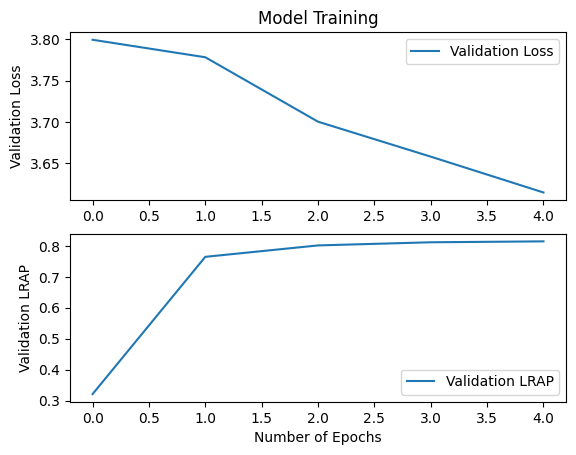

In [36]:
# using new prep_infused_sweetnet to generate glm-infused SweetNet model

from glycowork.ml import model_training
classes = len(labels[0]) # number of classes in the dataset
dataloaders = glycan_loaders
model =  prep_infused_sweetnet(
            initialization_method = 'random',
            num_classes = classes,
            embeddings_dict = glm_embeddings, 
            trainable_embeddings = True
            ) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes)
model_ft = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 5, mode = 'multilabel',)

In [ ]:
# using new prep_infused_sweetnet to generate glm-infused SweetNet model

from glycowork.ml import model_training
classes = len(labels[0]) # number of classes in the dataset
dataloaders = glycan_loaders
model =  prep_infused_sweetnet(
            initialization_method = 'external',
            num_classes = classes,
            embeddings_dict = glm_embeddings, 
            trainable_embeddings = True
            ) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel',)

In [ ]:
print(model.item_embedding.weight.data[3])
print(model.item_embedding.weight.data[10])
print(model.item_embedding.weight.data[42])

In [ ]:
# using standard prep_model

from glycowork.ml import model_training
classes = len(labels[0]) # number of classes in the dataset
dataloaders = glycan_loaders
model =  prep_model('SweetNet', classes) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel')

In [ ]:
# Lets Try with my new glm-infused data

from glycowork.ml import model_training

classes = len(labels[0]) # number of classes in the dataset
dataloaders = glycan_loaders_emb
model = prep_model('SweetNet', classes, use_external_embeddings = True) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes) #changed to 0.01 from 0.005 from 0.0005
model_ft = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel', use_external_embeddings = True)
